In [6]:
# !pip install optuna
# !pip install nevergrad
# !pip install scikit-optimize

## Methods in Nested-Arch HPO Benchmark

### Random / Baseline
- **RandomSuggestor** → Pure random sampling of architectures.
- **Skopt-Random (dummy)** → Random baseline from scikit-optimize.

### Evolutionary / Heuristic
- **SimulatedAnnealing** → Local search with neighbor perturbations, accepts worse solutions with probability based on temperature schedule.

### Bayesian Optimization (BO)
- **Optuna-TPE** → Tree-structured Parzen Estimator (KDE-based surrogate).
- **Skopt-GP** → Gaussian Process surrogate with Expected Improvement (classical BO).
- **Skopt-RF** → Random Forest surrogate.
- **Skopt-ET** → Extra-Trees surrogate.
- **Skopt-GBRT** → Gradient-Boosted Regression Trees surrogate.


In [2]:
import sys
sys.path.append('../src')

In [10]:
import random
from typing import Dict, List

def generate_network_modifiers_with_step(
    n_sets: int = 10,
    k_rows: int = 5,
    step: float = 0.05,
    seed: int = 42,
) -> List[Dict[int, List[float]]]:
    """
    Generate n_sets NETWORK_MODIFIERS dicts (keys 0..k_rows-1) with the following constraints:
      - Col 0: NE weights, sum to 1 across rows
      - Col 1: QPS weights, sum to 1 across rows
      - Col 2: flops importance, between [0.5, 1.0], step increments of 0.05
      - Col 3: flax (narrowness), between [0.05, 0.5], step increments of 0.05
      - Col 4: depth (how long), between [0.05, 0.5], step increments of 0.05
    """
    rng = random.Random(seed)
    out: List[Dict[int, List[float]]] = []

    def _sample_step(lo: float, hi: float) -> float:
        """Sample uniformly on a grid with step size `step` between lo and hi."""
        n_steps = int(round((hi - lo) / step))
        idx = rng.randint(0, n_steps)
        return round(lo + idx * step, 2)

    def _dirichlet_step(k: int) -> List[float]:
        """
        Sample k positive numbers, normalize to sum to 1.0, then
        round each to step and renormalize to exactly 1.
        """
        xs = [rng.random() + 1e-9 for _ in range(k)]
        s = sum(xs)
        xs = [x / s for x in xs]
        xs = [round(x / step) * step for x in xs]  # quantize
        s2 = sum(xs)
        # Avoid zero division; if rounding kills too much, fix one entry
        if s2 == 0:
            xs[0] = 1.0
            s2 = 1.0
        # Renormalize so they sum exactly to 1.0 again
        xs = [x / s2 for x in xs]
        # Final rounding to keep nice format
        xs = [round(x, 4) for x in xs]
        return xs

    for _ in range(n_sets):
        # First two columns: normalized to 1
        col0 = _dirichlet_step(k_rows)
        col1 = _dirichlet_step(k_rows)

        nm: Dict[int, List[float]] = {}
        for i in range(k_rows):
            c2 = _sample_step(0.5, 1.0)    # flops
            c3 = _sample_step(0.05, 0.5)   # flax
            c4 = _sample_step(0.05, 0.5)   # depth
            nm[i] = [col0[i], col1[i], c2, c3, c4]
        out.append(nm)

    return out

# --- ADD THIS ANYWHERE ABOVE run_all() ---
def save_generated_networks_csv(path: str, n_trials: int, seed: int) -> None:
    """
    Save N_TRIALS architectures (first is BASELINE_ARCH, rest are random samples)
    to a simple CSV: 'Idx, Arch'.
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)

    rng = np.random.RandomState(seed)
    rows = []
    # 1) Start with the baseline arch
    rows.append((1, BASELINE_ARCH))
    # 2) Sample the remaining arches
    for i in range(2, n_trials + 1):
        rows.append((i, sample_arch(rng)))

    with open(path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["Idx", "Arch"])
        for idx, arch in rows:
            w.writerow([idx, json.dumps(arch)])

networks_csv_path = os.path.join("..", "tasks", "10 tries @60days no noise", "networks.csv")
save_generated_networks_csv(
    path=networks_csv_path,
    n_trials=N_TRIALS,
    seed=SEEDS[0] if SEEDS else 0,
)


# -------- Example usage --------
if __name__ == "__main__":
    sets = generate_network_modifiers_with_step(n_sets=10, seed=123)
    for idx, nm in enumerate(sets):
        print(f"\nSet #{idx+1}:")
        for k in range(5):
            print(k, nm[k])
    # Validate first set column sums
    first = sets[0]
    print("\ncol0 sum:", sum(first[i][0] for i in range(5)))
    print("col1 sum:", sum(first[i][1] for i in range(5)))



Set #1:
0 [0.05, 0.0, 0.75, 0.45, 0.3]
1 [0.05, 0.3, 0.65, 0.15, 0.05]
2 [0.25, 0.15, 0.8, 0.1, 0.5]
3 [0.05, 0.45, 0.8, 0.1, 0.05]
4 [0.6, 0.1, 0.75, 0.4, 0.1]

Set #2:
0 [0.4737, 0.25, 0.75, 0.45, 0.4]
1 [0.0526, 0.15, 0.65, 0.5, 0.45]
2 [0.0526, 0.1, 0.95, 0.3, 0.05]
3 [0.4211, 0.25, 0.8, 0.45, 0.35]
4 [0.0, 0.25, 1.0, 0.45, 0.5]

Set #3:
0 [0.3684, 0.25, 0.6, 0.3, 0.3]
1 [0.2105, 0.05, 0.9, 0.35, 0.1]
2 [0.2632, 0.25, 0.85, 0.35, 0.5]
3 [0.1579, 0.25, 0.75, 0.05, 0.2]
4 [0.0, 0.2, 0.95, 0.1, 0.3]

Set #4:
0 [0.0, 0.2, 0.65, 0.45, 0.4]
1 [0.2, 0.15, 0.6, 0.15, 0.45]
2 [0.1, 0.25, 0.85, 0.35, 0.4]
3 [0.3, 0.25, 0.5, 0.05, 0.15]
4 [0.4, 0.15, 0.85, 0.2, 0.05]

Set #5:
0 [0.15, 0.1, 0.5, 0.45, 0.35]
1 [0.2, 0.05, 0.55, 0.45, 0.35]
2 [0.15, 0.35, 0.5, 0.3, 0.25]
3 [0.25, 0.1, 0.85, 0.05, 0.45]
4 [0.25, 0.4, 0.75, 0.35, 0.3]

Set #6:
0 [0.0, 0.25, 1.0, 0.05, 0.45]
1 [0.35, 0.05, 0.8, 0.45, 0.25]
2 [0.1, 0.2, 0.6, 0.25, 0.35]
3 [0.5, 0.25, 0.75, 0.15, 0.45]
4 [0.05, 0.25, 0.75, 0.45, 0.1

[I 2025-10-01 16:59:45,554] A new study created in memory with name: no-name-85f89227-bbd6-41d3-bd3c-9e1b415671bc


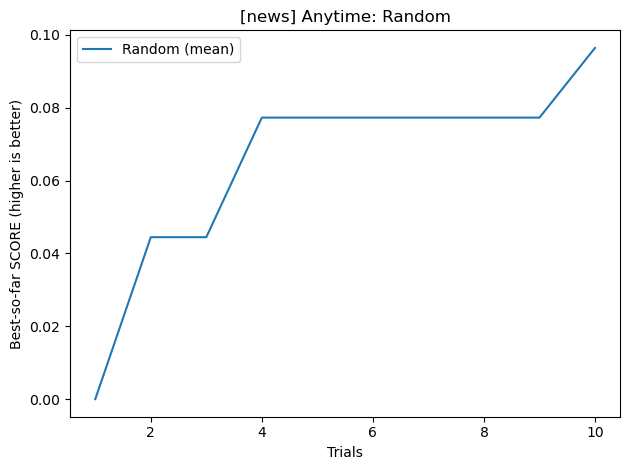

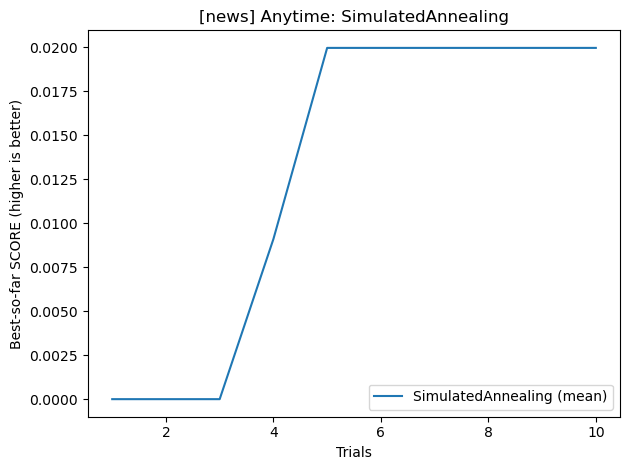

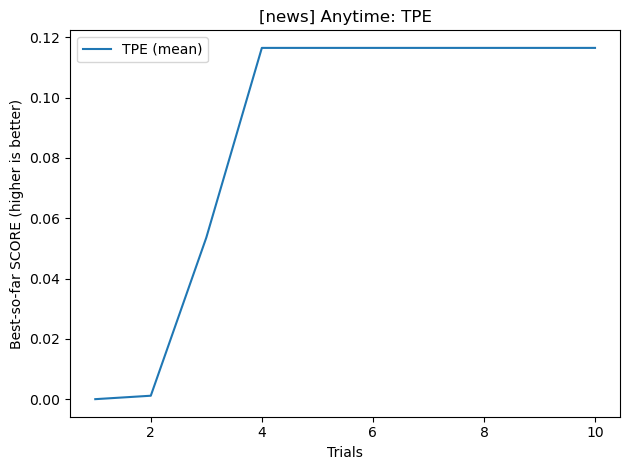

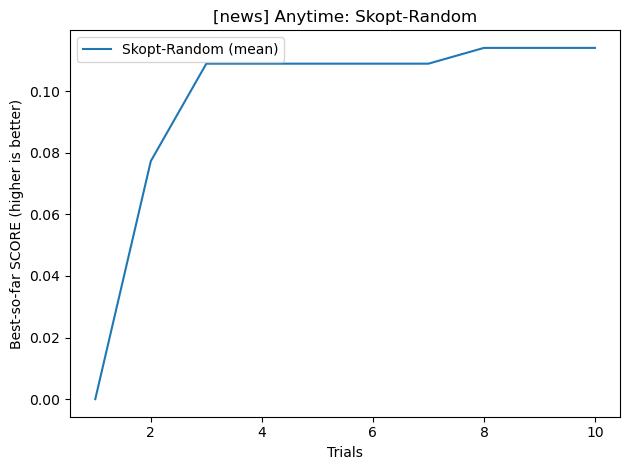

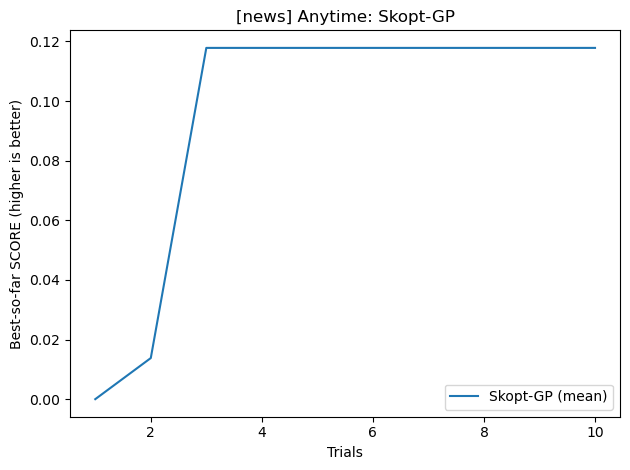

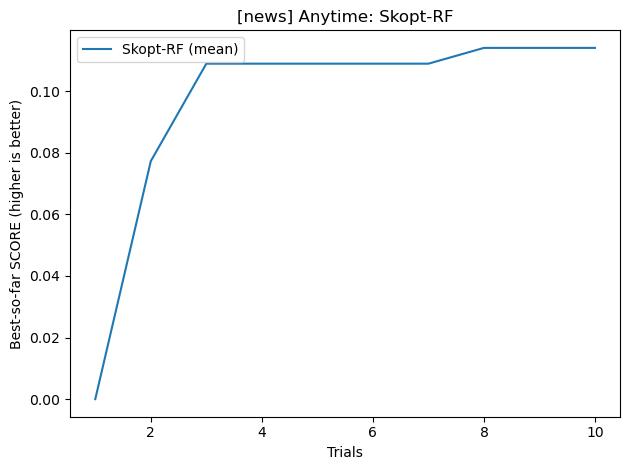

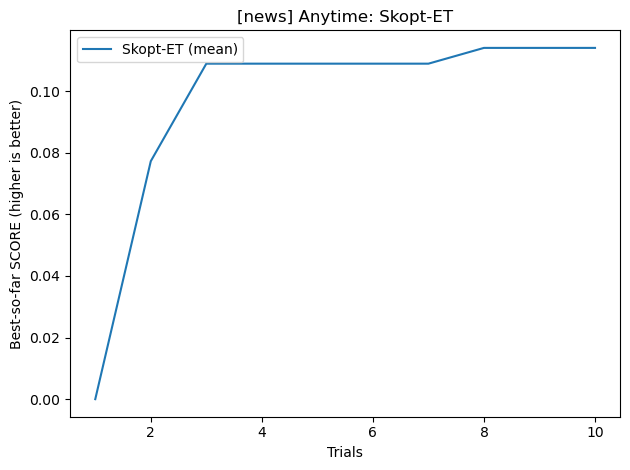

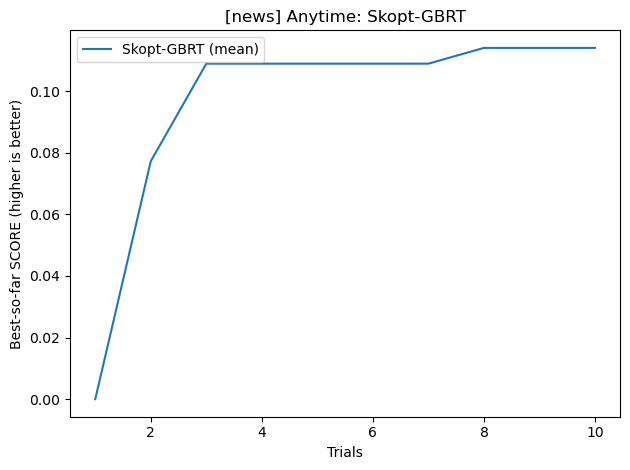

[I 2025-10-01 16:59:49,579] A new study created in memory with name: no-name-2e260fda-7981-4bf5-bf42-dbbaf47709c6


[news] Saved CSVs to: /shared_data0/weiqiuy/ads_mle_simulation/notebooks/benchmark_results_nested_arch/news
[news] Methods: ['Random', 'SimulatedAnnealing', 'TPE', 'Skopt-Random', 'Skopt-GP', 'Skopt-RF', 'Skopt-ET', 'Skopt-GBRT']
[news] BASELINE_NE (computed) = 0.555529
[news] Ranges: width=[64..2048] (log 7 levels), layers/sub_arch=[1..5], sub_arches=[1..5]
[news] [baseline] arch=[[256, 256], [512, 512], [256, 256], [64], [64]], days=60
------------------------------------------------------------------------


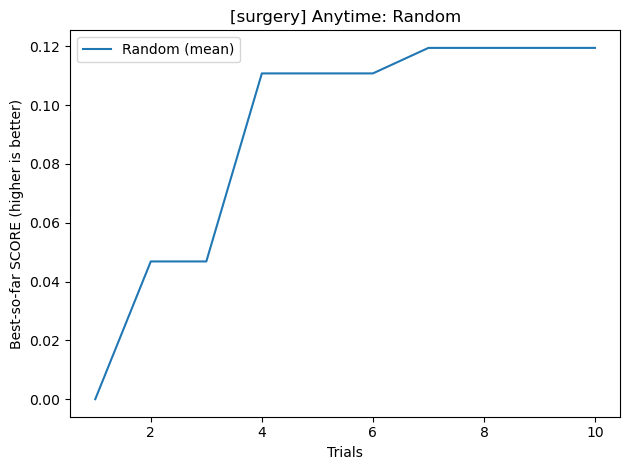

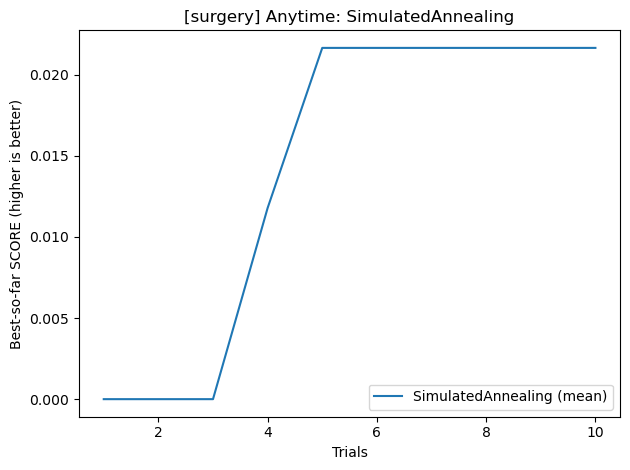

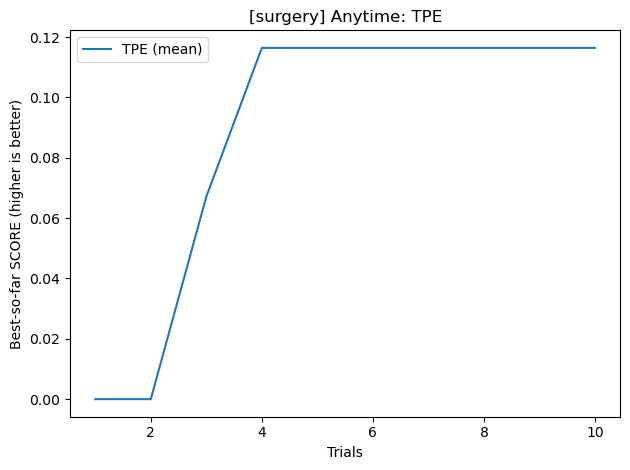

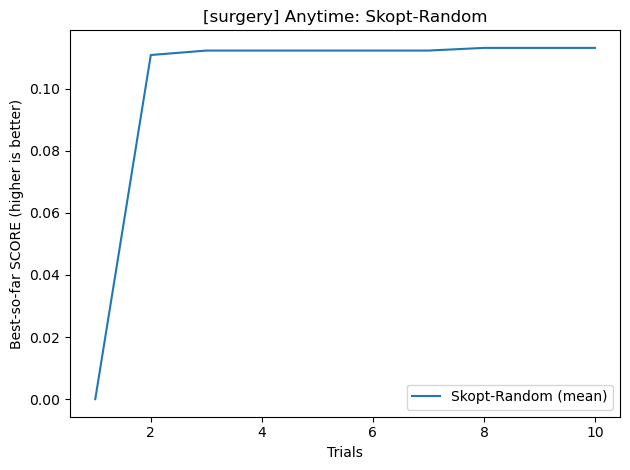

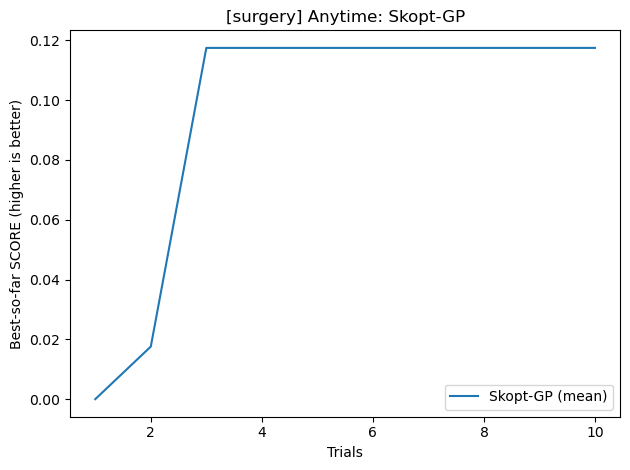

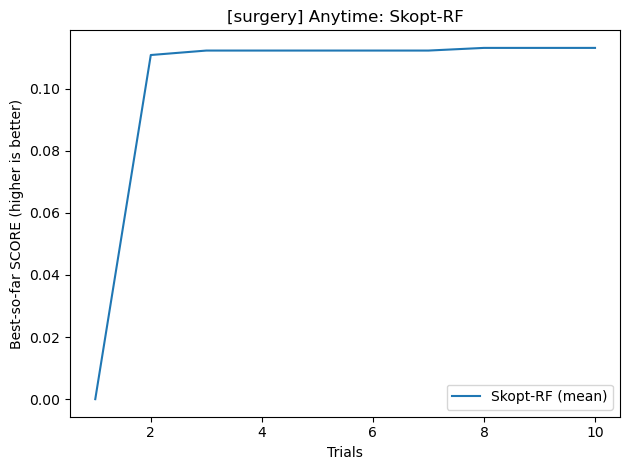

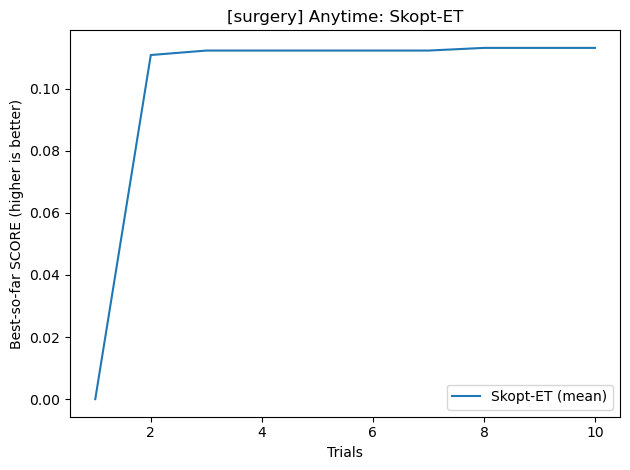

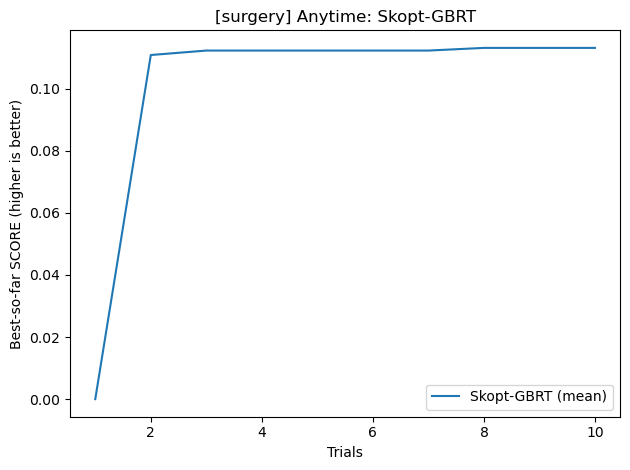

[surgery] Saved CSVs to: /shared_data0/weiqiuy/ads_mle_simulation/notebooks/benchmark_results_nested_arch/surgery
[surgery] Methods: ['Random', 'SimulatedAnnealing', 'TPE', 'Skopt-Random', 'Skopt-GP', 'Skopt-RF', 'Skopt-ET', 'Skopt-GBRT']
[surgery] BASELINE_NE (computed) = 0.554222
[surgery] Ranges: width=[64..2048] (log 7 levels), layers/sub_arch=[1..5], sub_arches=[1..5]
[surgery] [baseline] arch=[[256, 256], [512, 512], [256, 256], [64], [64]], days=60
------------------------------------------------------------------------


In [9]:

# === NESTED-ARCH HPO (MAXIMIZATION) with sub_arches + QPS gate ===
from __future__ import annotations
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Tuple, Callable
import time, math, random, json, csv
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from model_performance_api import ModelPerformanceAPI

# ---------------------------------------------------------------------
# GLOBAL SETTINGS
# ---------------------------------------------------------------------
EVAL_TRAINING_DAYS = 60
N_TRIALS            = 10
SEEDS               = [0]  # run once per suggestor by default

# Ranges
WIDTH_MIN, WIDTH_MAX = 64, 2048
MIN_LAYERS_PER_SUB, MAX_LAYERS_PER_SUB = 1, 5
MIN_SUBARCHES,      MAX_SUBARCHES      = 1, 5

# Discrete width ladder (log-scale to keep search sane)
N_WIDTH_LEVELS = 7

# QPS gate
QPS_MIN = 3500.0

# Baseline (nested format)
BASELINE_ARCH: List[List[int]] = [[256,256], [512,512], [256,256], [64], [64]]

# Results root directory
OUT_ROOT = Path("benchmark_results_nested_arch")

# ---------------------------------------------------------------------
# Provide your list of (label, NETWORK_MODIFIERS) pairs here.
# Each entry will be run independently with its own ModelPerformanceAPI and outputs.
# ---------------------------------------------------------------------
NETWORK_MODIFIERS_LIST: List[Tuple[str, Dict[int, List[float]]]] = [
    ("1", {
        0: [0.25, 0.20, 1.00, 0.10, 0.10],
        1: [0.35, 0.25, 0.80, 0.05, 0.05],
        2: [0.15, 0.15, 0.70, 0.30, 0.05],
        3: [0.15, 0.25, 0.60, 0.40, 0.05],
        4: [0.10, 0.15, 0.90, 0.10, 0.10],
    }),
    ("2", {
        0: [0.30, 0.15, 0.90, 0.15, 0.10],
        1: [0.30, 0.25, 0.75, 0.05, 0.05],
        2: [0.10, 0.20, 0.65, 0.35, 0.05],
        3: [0.20, 0.25, 0.70, 0.25, 0.05],
        4: [0.10, 0.15, 0.85, 0.10, 0.10],
    }),
]

# ---------------------------------------------------------------------
# Helpers
# ---------------------------------------------------------------------
def _logspace_ints(lo: int, hi: int, n: int) -> List[int]:
    xs = np.exp(np.linspace(np.log(lo), np.log(hi), n))
    arr = np.rint(xs).astype(int).tolist()
    arr[0], arr[-1] = lo, hi
    for i in range(1, len(arr)):
        arr[i] = max(arr[i], arr[i-1])
    return sorted(list(dict.fromkeys(arr)))

WIDTH_LEVELS = _logspace_ints(WIDTH_MIN, WIDTH_MAX, N_WIDTH_LEVELS)

def _valid_layer_size(w: int) -> bool:
    return isinstance(w, int) and (WIDTH_MIN <= w <= WIDTH_MAX)

def validate_arch_nested(arch: List[List[int]]) -> None:
    assert isinstance(arch, list) and (MIN_SUBARCHES <= len(arch) <= MAX_SUBARCHES), \
        f"arch must have {MIN_SUBARCHES}-{MAX_SUBARCHES} sub_arches, got {len(arch)}"
    for sub in arch:
        assert isinstance(sub, list) and (MIN_LAYERS_PER_SUB <= len(sub) <= MAX_LAYERS_PER_SUB), \
            f"each sub_arch must have {MIN_LAYERS_PER_SUB}-{MAX_LAYERS_PER_SUB} layers, got {len(sub)}"
        for w in sub:
            assert _valid_layer_size(w), f"layer size {w} out of range [{WIDTH_MIN}, {WIDTH_MAX}]"

def sample_subarch(rng: np.random.RandomState) -> List[int]:
    depth = int(rng.randint(MIN_LAYERS_PER_SUB, MAX_LAYERS_PER_SUB + 1))
    w = int(WIDTH_LEVELS[int(rng.randint(0, len(WIDTH_LEVELS)))])
    return [w] * depth

def sample_arch(rng: np.random.RandomState) -> List[List[int]]:
    s = int(rng.randint(MIN_SUBARCHES, MAX_SUBARCHES + 1))
    return [sample_subarch(rng) for _ in range(s)]

def neighbor_arch(rng: np.random.RandomState, arch: List[List[int]]) -> List[List[int]]:
    """Local edit: tweak width/depth of a random sub_arch, or add/remove a sub_arch."""
    arch = [list(sub) for sub in arch]  # deep copy
    op = rng.choice(["width", "depth", "add", "remove"], p=[0.4, 0.35, 0.15, 0.10])

    if len(arch) == 0:
        return sample_arch(rng)

    if op == "width":
        i = int(rng.randint(0, len(arch)))
        cur_w = arch[i][0]
        k = int(np.argmin([abs(math.log(max(1, cur_w)) - math.log(w)) for w in WIDTH_LEVELS]))
        if len(WIDTH_LEVELS) > 1:
            step = rng.choice([-1, 1])
            k = max(0, min(len(WIDTH_LEVELS) - 1, k + step))
        arch[i] = [int(WIDTH_LEVELS[k])] * len(arch[i])

    elif op == "depth":
        i = int(rng.randint(0, len(arch)))
        d = len(arch[i])
        if rng.rand() < 0.5 and d > MIN_LAYERS_PER_SUB:
            arch[i] = arch[i][:-1]
        elif d < MAX_LAYERS_PER_SUB:
            arch[i] = arch[i] + [arch[i][0]]

    elif op == "add" and len(arch) < MAX_SUBARCHES:
        arch.append(sample_subarch(rng))

    elif op == "remove" and len(arch) > MIN_SUBARCHES:
        i = int(rng.randint(0, len(arch)))
        arch.pop(i)

    try:
        validate_arch_nested(arch)
        return arch
    except AssertionError:
        return sample_arch(rng)

# ---------------------------------------------------------------------
# Search API (space-less suggestors over nested arch)
# ---------------------------------------------------------------------
@dataclass
class Trial:
    config: Dict[str, Any]
    value: float
    elapsed: float
    seed: int

@dataclass
class RunLog:
    method: str
    trials: List[Trial]
    def best_curve(self) -> List[float]:
        best = -float("inf")
        out = []
        for t in self.trials:
            best = max(best, t.value)
            out.append(best)
        return out

class Suggestor:
    name: str = "Suggestor"
    def reset(self, seed: int): ...
    def ask(self, rng: np.random.RandomState, state: Optional[Dict[str, Any]]) -> Dict[str, Any]: ...
    def tell(self, config: Dict[str, Any], value: float): ...

class RandomSuggestor(Suggestor):
    name = "Random"
    def reset(self, seed: int): random.seed(seed)
    def ask(self, rng: np.random.RandomState, state: Optional[Dict[str, Any]]) -> Dict[str, Any]:
        return {"arch": sample_arch(rng)}
    def tell(self, config: Dict[str, Any], value: float): pass

class SimulatedAnnealingSuggestor(Suggestor):
    name = "SimulatedAnnealing"
    def __init__(self, T0: float=0.5, alpha: float=0.996, warmup: int=3):
        self.T0 = T0; self.alpha = alpha; self.warmup = warmup
        self._x = None; self._fx = None; self._T = T0
        self._n_evals = 0
    def reset(self, seed: int):
        random.seed(seed)
        self._x = None; self._fx = None; self._T = self.T0
        self._n_evals = 0
    def ask(self, rng: np.random.RandomState, state: Optional[Dict[str, Any]]) -> Dict[str, Any]:
        if (self._x is None) or (self._n_evals < self.warmup):
            cfg = {"arch": sample_arch(rng)} if state is None else state
        else:
            cfg = {"arch": neighbor_arch(rng, self._x["arch"])}
        return cfg
    def tell(self, config: Dict[str, Any], value: float):
        self._n_evals += 1
        if self._fx is None:
            self._x, self._fx = config, float(value)
            return
        if self._n_evals <= self.warmup:
            if value > self._fx:
                self._x, self._fx = config, float(value)
            return
        delta = float(value) - float(self._fx)
        accept = (delta >= 0) or (random.random() < math.exp(delta / max(self._T, 1e-12)))
        if accept:
            self._x, self._fx = config, float(value)
        self._T *= self.alpha

# ---------------------------------------------------------------------
# Scoring (QPS gate + percent improvement vs baseline NE)
# We rely on the model's get_score(ne) which uses its BASELINE_NE (computed from BASELINE_ARCH).
# ---------------------------------------------------------------------
def make_evaluator(model_object: ModelPerformanceAPI) -> Callable[[Dict[str, Any]], float]:
    def score_from_model(ne: float, qps: float) -> float:
        if qps <= QPS_MIN:
            return -100.0
        return float(model_object.get_score(ne))

    def evaluate_cfg(cfg: Dict[str, Any]) -> float:
        arch = cfg["arch"]
        validate_arch_nested(arch)
        ne, qps, _ = model_object.train_model(
            arch=arch,
            training_days=EVAL_TRAINING_DAYS,
            ignore_budget=True
        )
        return score_from_model(ne=float(ne), qps=float(qps))
    return evaluate_cfg

# ---------------------------------------------------------------------
# Benchmark (all methods can start with the same initial seed if provided)
# ---------------------------------------------------------------------
class Benchmark:
    def __init__(self, evaluate_fn: Callable[[Dict[str, Any]], float]):
        self.evaluate = evaluate_fn

    def run(self, suggestor: Suggestor, n_trials: int=N_TRIALS, seed: int=0,
            initial_arch: Optional[List[List[int]]] = None) -> RunLog:
        rng = np.random.RandomState(seed)
        random.seed(seed)
        suggestor.reset(seed)
        trials: List[Trial] = []

        used = 0
        state = None
        if initial_arch is not None:
            validate_arch_nested(initial_arch)
            cfg0 = {"arch": initial_arch}
            t0 = time.time()
            val0 = float(self.evaluate(cfg0))
            dt0 = time.time() - t0
            suggestor.tell(cfg0, val0)
            trials.append(Trial(cfg0, val0, dt0, seed))
            state = cfg0
            used = 1

        for _ in range(n_trials - used):
            cfg = suggestor.ask(rng, state)
            t0 = time.time()
            val = float(self.evaluate(cfg))
            dt = time.time() - t0
            suggestor.tell(cfg, val)
            trials.append(Trial(cfg, val, dt, seed))
            state = cfg
        return RunLog(method=suggestor.name, trials=trials)

# ---------------------------------------------------------------------
# Logging & plotting
# ---------------------------------------------------------------------
def save_runs(results: Dict[str, List[RunLog]], out_dir: Path):
    out_dir.mkdir(exist_ok=True, parents=True)
    for method, runs in results.items():
        for i, run in enumerate(runs):
            fp = out_dir / f"{method}_seed{i}.csv"
            with fp.open("w", newline="") as f:
                w = csv.writer(f)
                w.writerow(["step","best_so_far","value","elapsed","config_json"])
                best = -float("inf")
                for t, tr in enumerate(run.trials, start=1):
                    best = max(best, tr.value)
                    w.writerow([t, best, tr.value, tr.elapsed, json.dumps(tr.config)])

def save_arches_per_method(results: Dict[str, List[RunLog]], out_dir: Path):
    out_dir.mkdir(exist_ok=True, parents=True)
    for method, runs in results.items():
        fp = out_dir / f"{method}_arches.csv"
        with fp.open("w", newline="") as f:
            w = csv.writer(f)
            w.writerow(["seed","step","arch_json","score"])
            for i, run in enumerate(runs):
                seed_id = run.trials[0].seed if run.trials else i
                for step, tr in enumerate(run.trials, start=1):
                    w.writerow([seed_id, step, json.dumps(tr.config.get("arch")), tr.value])

def plot_runs(results: Dict[str, List[RunLog]], title_prefix: str):
    for method, runs in results.items():
        if not runs:
            continue
        L = min(len(r.trials) for r in runs)
        curves = np.array([r.best_curve()[:L] for r in runs], dtype=float)
        mean, std = curves.mean(0), curves.std(0)
        x = np.arange(1, L+1)
        plt.figure()
        plt.plot(x, mean, label=f"{method} (mean)")
        plt.fill_between(x, mean-std, mean+std, alpha=0.2)
        plt.xlabel("Trials")
        plt.ylabel("Best-so-far SCORE (higher is better)")
        plt.title(f"{title_prefix}Anytime: {method}")
        plt.legend(); plt.tight_layout(); plt.show()

# ---- Optuna encode/decode for nested archs ----
def arch_to_params(arch: List[List[int]]) -> Dict[str, Any]:
    validate_arch_nested(arch)
    params: Dict[str, Any] = {}
    n_sub = len(arch)
    params["n_sub"] = n_sub
    for i, sub in enumerate(arch):
        d = len(sub)
        w = sub[0]
        k = int(np.argmin([abs(math.log(max(1, w)) - math.log(v)) for v in WIDTH_LEVELS]))
        params[f"depth_{i}"] = d
        params[f"widx_{i}"] = k
    for i in range(n_sub, MAX_SUBARCHES):
        params[f"depth_{i}"] = 1
        params[f"widx_{i}"]  = 0
    return params

def params_to_arch(params: Dict[str, Any]) -> List[List[int]]:
    n_sub = int(params["n_sub"])
    n_sub = max(MIN_SUBARCHES, min(MAX_SUBARCHES, n_sub))
    arch: List[List[int]] = []
    for i in range(n_sub):
        d = int(params[f"depth_{i}"]); d = max(MIN_LAYERS_PER_SUB, min(MAX_LAYERS_PER_SUB, d))
        k = int(params[f"widx_{i}"]);  k = max(0, min(len(WIDTH_LEVELS)-1, k))
        w = int(WIDTH_LEVELS[k])
        arch.append([w] * d)
    validate_arch_nested(arch)
    return arch

# ---- Optuna TPE suggestor for nested arch ----
class TPESuggestor(Suggestor):
    name = "TPE"
    def __init__(self, initial_arch: Optional[List[List[int]]] = None):
        try:
            import optuna  # noqa: F401
        except Exception as e:
            raise RuntimeError("Optuna not available: pip install -U optuna") from e
        self._optuna = __import__("optuna")
        self._study = None
        self._last_trial = None
        self._initial_arch = initial_arch

    def reset(self, seed: int):
        sampler = self._optuna.samplers.TPESampler(seed=seed)
        self._study = self._optuna.create_study(direction="maximize", sampler=sampler)
        self._last_trial = None
        if self._initial_arch is not None:
            try:
                validate_arch_nested(self._initial_arch)
                self._study.enqueue_trial(arch_to_params(self._initial_arch))
            except Exception:
                pass

    def ask(self, rng: np.random.RandomState, state: Optional[Dict[str, Any]]) -> Dict[str, Any]:
        trial = self._study.ask()
        n_sub = trial.suggest_int("n_sub", MIN_SUBARCHES, MAX_SUBARCHES)
        for i in range(MAX_SUBARCHES):
            trial.suggest_int(f"depth_{i}", MIN_LAYERS_PER_SUB, MAX_LAYERS_PER_SUB)
            trial.suggest_int(f"widx_{i}", 0, len(WIDTH_LEVELS) - 1)
        params = dict(trial.params); params["n_sub"] = n_sub
        cfg = {"arch": params_to_arch(params)}
        self._last_trial = trial
        return cfg

    def tell(self, config: Dict[str, Any], value: float):
        if self._last_trial is not None:
            self._study.tell(self._last_trial, float(value))
            self._last_trial = None

# ---- skopt helpers: vectorize params <-> x ----
def params_to_x(params: Dict[str, Any]) -> List[int]:
    x = [int(params["n_sub"])]
    for i in range(MAX_SUBARCHES):
        x.append(int(params[f"depth_{i}"]))
    for i in range(MAX_SUBARCHES):
        x.append(int(params[f"widx_{i}"]))
    return x

def x_to_params(x: List[int]) -> Dict[str, Any]:
    idx = 0
    n_sub = int(x[idx]); idx += 1
    params: Dict[str, Any] = {"n_sub": n_sub}
    for i in range(MAX_SUBARCHES):
        params[f"depth_{i}"] = int(x[idx]); idx += 1
    for i in range(MAX_SUBARCHES):
        params[f"widx_{i}"] = int(x[idx]); idx += 1
    return params

# ---- scikit-optimize wrappers ----
class SkoptBOSuggestor(Suggestor):
    """ base can be one of: "GP", "RF", "ET", "GBRT", "dummy" """
    def __init__(self, base: str = "GP", name: Optional[str] = None):
        try:
            import skopt  # noqa: F401
            from skopt import Optimizer
            from skopt.space import Integer
        except Exception as e:
            raise RuntimeError("scikit-optimize not available: pip install scikit-optimize") from e

        self._skopt = __import__("skopt")
        self._Optimizer = self._skopt.Optimizer
        self._Integer = self._skopt.space.Integer
        self.base = base
        self.name = name or f"Skopt-{base}"
        self.opt = None
        self._last_x = None

        self._space = [
            self._Integer(MIN_SUBARCHES, MAX_SUBARCHES, name="n_sub"),
            *[self._Integer(MIN_LAYERS_PER_SUB, MAX_LAYERS_PER_SUB, name=f"depth_{i}")
              for i in range(MAX_SUBARCHES)],
            *[self._Integer(0, len(WIDTH_LEVELS)-1, name=f"widx_{i}")
              for i in range(MAX_SUBARCHES)],
        ]

    def reset(self, seed: int):
        self.opt = self._Optimizer(
            dimensions=self._space,
            base_estimator=self.base,
            random_state=seed,
            acq_func="EI",
        )
        self._last_x = None

    def ask(self, rng: np.random.RandomState, state: Optional[Dict[str, Any]]) -> Dict[str, Any]:
        x = self.opt.ask()
        params = x_to_params(x)
        cfg = {"arch": params_to_arch(params)}
        self._last_x = x
        return cfg

    def tell(self, config: Dict[str, Any], value: float):
        y = -float(value)  # skopt minimizes
        if self._last_x is not None:
            x = self._last_x
            self._last_x = None
        else:
            arch = config["arch"]
            params = arch_to_params(arch)
            x = params_to_x(params)
        self.opt.tell(x, y)

# ---------------------------------------------------------------------
# MAIN LOOP over NETWORK_MODIFIERS_LIST
# ---------------------------------------------------------------------
def run_all():
    all_runs_by_label: Dict[str, Dict[str, List[RunLog]]] = {}

    for label, NETWORK_MODIFIERS in NETWORK_MODIFIERS_LIST:
        # fresh model object for this set of modifiers
        cfg = {
            "GLOBAL_NOISE_SCALE": 0.0,             # deterministic if desired
            "BASELINE_ARCH": BASELINE_ARCH,        # BASELINE_NE will be computed from this
            "BASELINE_DAY": EVAL_TRAINING_DAYS,
            "NETWORK_MODIFIERS": NETWORK_MODIFIERS,
        }
        model_object = ModelPerformanceAPI(cfg)

        # evaluator & benchmark for this model
        evaluate_cfg = make_evaluator(model_object)
        bench = Benchmark(evaluate_cfg)

        # Suggestors
        suggestors: List[Suggestor] = [
            RandomSuggestor(),
            SimulatedAnnealingSuggestor(T0=0.5, alpha=0.996, warmup=3),
        ]
        try:
            suggestors.append(TPESuggestor(initial_arch=BASELINE_ARCH))
        except Exception as e:
            print(f"[{label}] TPE disabled:", e)
        try:
            suggestors += [
                SkoptBOSuggestor("dummy", name="Skopt-Random"),
                SkoptBOSuggestor("GP",    name="Skopt-GP"),
                SkoptBOSuggestor("RF",    name="Skopt-RF"),
                SkoptBOSuggestor("ET",    name="Skopt-ET"),
                SkoptBOSuggestor("GBRT",  name="Skopt-GBRT"),
            ]
        except Exception as e:
            print(f"[{label}] skopt baselines disabled:", e)

        # Run
        results: Dict[str, List[RunLog]] = {}
        for sug in suggestors:
            results[sug.name] = []
            for s in SEEDS:
                results[sug.name].append(
                    bench.run(sug, n_trials=N_TRIALS, seed=s, initial_arch=BASELINE_ARCH)
                )

        # Save & plot under a per-label folder
        out_dir = OUT_ROOT / label
        save_runs(results, out_dir)
        save_arches_per_method(results, out_dir)
        plot_runs(results, title_prefix=f"[{label}] ")

        # Metadata/prints
        cfg_copy = model_object.get_default_model_config_dict()
        baseline_ne = cfg_copy["BASELINE_NE"]
        print(f"[{label}] Saved CSVs to: {out_dir.resolve()}")
        print(f"[{label}] Methods: {list(results.keys())}")
        print(f"[{label}] BASELINE_NE (computed) = {baseline_ne:.6f}")
        print(f"[{label}] Ranges: width=[{WIDTH_MIN}..{WIDTH_MAX}] (log {N_WIDTH_LEVELS} levels), "
              f"layers/sub_arch=[{MIN_LAYERS_PER_SUB}..{MAX_LAYERS_PER_SUB}], sub_arches=[{MIN_SUBARCHES}..{MAX_SUBARCHES}]")
        print(f"[{label}] [baseline] arch={BASELINE_ARCH}, days={EVAL_TRAINING_DAYS}")
        print("-"*72)

        all_runs_by_label[label] = results

    return all_runs_by_label

if __name__ == "__main__":
    run_all()


In [5]:
# ---------------------------------------------------------------------
# Results report (only optimizers + baseline info)
# ---------------------------------------------------------------------
from pathlib import Path

REPORT_DIR = Path("../tasks/10 tries @60days no noise")
REPORT_DIR.mkdir(parents=True, exist_ok=True)
REPORT_PATH = REPORT_DIR / "results_baselines.txt"

def _best_trial_score(runlog):
    return max((t.value for t in runlog.trials), default=float("-inf"))

def summarize_results(results_dict: Dict[str, List[RunLog]]):
    # Best single trial across all seeds for each method
    method_best = {}
    for method, runs in results_dict.items():
        best = float("-inf")
        for r in runs:
            best = max(best, _best_trial_score(r))
        method_best[method] = best if best != float("-inf") else 0.0
    return method_best

method_best = summarize_results(results)

lines = []
lines.append("Reults:\n")  # keeping the spelling consistent with your sample

# --- Rules based (optimizers) section ---
lines.append("Rules based (optimizers): (target 3)")
for method in sorted(method_best.keys()):
    lines.append(f"{method} {method_best[method]:.6f}")

# Baseline info
lines.append("")
lines.append(f"[baseline] arch={BASELINE_ARCH} days={EVAL_TRAINING_DAYS} NE={BASELINE_NE:.6f}")
if INITIAL_ARCH is not None:
    lines.append(f"[seed] initial arch: {INITIAL_ARCH}")

with REPORT_PATH.open("w", encoding="utf-8") as f:
    f.write("\n".join(lines) + "\n")

print(f"Wrote report to: {REPORT_PATH.resolve()}")

# ---------------------------------------------------------------------
# Detailed results report (all searched arches)
# ---------------------------------------------------------------------
DETAILS_PATH = REPORT_DIR / "results_details_baselines.txt"

with DETAILS_PATH.open("w", encoding="utf-8") as f:
    f.write("Reults Details:\n\n")  # keep consistent header spelling

    for method, runs in results.items():
        f.write(f"Method: {method}\n")
        for i, run in enumerate(runs):
            seed_id = run.trials[0].seed if run.trials else i
            f.write(f"  Seed {seed_id}:\n")
            for step, tr in enumerate(run.trials, start=1):
                arch_str = json.dumps(tr.config.get("arch"))
                f.write(f"    Step {step}: arch={arch_str}, score={tr.value:.6f}\n")
        f.write("\n")

print(f"Wrote detailed report to: {DETAILS_PATH.resolve()}")


Wrote report to: /shared_data0/weiqiuy/ads_mle_simulation/tasks/10 tries @60days no noise/results_baselines.txt
Wrote detailed report to: /shared_data0/weiqiuy/ads_mle_simulation/tasks/10 tries @60days no noise/results_details_baselines.txt


In [6]:
import pandas as pd

def save_results_flat(results: Dict[str, List[RunLog]], out_csv: Path):
    rows = []
    for method, runs in results.items():
        for run in runs:
            for step, tr in enumerate(run.trials, start=1):
                arch = tr.config.get("arch")
                # Re-evaluate NE/QPS so we can log them
                ne, qps, curve = model_object.train_model(
                    arch=arch,
                    training_days=EVAL_TRAINING_DAYS,
                    ignore_budget=True
                )
                rows.append({
                    "Competitor": method,
                    "seed": tr.seed,
                    "step": step,
                    "Trial": step,                # duplicate of step for clarity
                    "Arch": json.dumps(arch),
                    "score": float(score_from_model(ne, qps)),
                    "qps": float(qps),
                    "ne": float(ne),
                })
    df = pd.DataFrame(rows,
                      columns=["Competitor","seed","step","Trial","Arch","score","qps","ne"])
    df.to_csv(out_csv, index=False)
    print("Saved:", out_csv.resolve())

out_csv = REPORT_DIR / "Sim_ML_Bench_l3_60days_10tries_baselines.csv"
save_results_flat(results, out_csv)


Saved: /shared_data0/weiqiuy/ads_mle_simulation/tasks/10 tries @60days no noise/Sim_ML_Bench_l3_60days_10tries_baselines.csv


=== SUMMARY (higher is better) ===


,method,aligned_trials,seeds,final_mean,final_std,auc_mean_curve
0,CMAES,10,10,0.311872,0.172035,2.819393
1,TPE,10,15,0.245045,0.174017,2.113294
2,Random,10,15,0.236390,0.178277,2.000362
3,SimulatedAnnealing,10,15,0.210856,0.213701,1.782686
4,Skopt-GP,10,5,0.122428,0.000948,0.925964
5,Skopt-ET,10,5,0.107574,0.021611,0.654954
6,Skopt-RF,10,5,0.107574,0.021611,0.654954
7,Skopt-Random,10,5,0.107574,0.021611,0.654954
8,Skopt-GBRT,10,5,0.107574,0.021611,0.654954


Saved: /shared_data0/weiqiuy/ads_mle_simulation/notebooks/benchmark_analytics_max/summary_max.csv

=== RANKS (by final best-so-far SCORE; higher is better) ===


,method,final_mean,rank_by_final
0,CMAES,0.311872,1
1,TPE,0.245045,2
2,Random,0.236390,3
3,SimulatedAnnealing,0.210856,4
4,Skopt-GP,0.122428,5
5,Skopt-ET,0.107574,6
6,Skopt-RF,0.107574,6
7,Skopt-Random,0.107574,6
8,Skopt-GBRT,0.107574,6



=== Best arch per seed (per method) ===


,method,seed,arch_json,score
0,CMAES,0,"[2048, 2048, 2048]",0.141109
1,CMAES,1,"[2048, 2048, 2048, 2048]",0.141109
2,CMAES,2,"[1290, 1290, 1290, 1290, 1290, 1290]",0.141109
3,CMAES,3,"[2048, 2048, 2048, 2048, 2048, 2048]",0.141109
4,CMAES,4,"[1290, 1290, 1290, 1290]",0.135126
5,Random,0,"[1290, 1290, 1290]",0.129395
6,Random,1,"[1290, 1290]",0.123665
7,Random,2,"[1290, 1290, 1290, 1290, 1290, 1290]",0.141109
8,Random,3,"[2048, 2048, 2048, 2048, 2048, 2048]",0.141109
9,Random,4,"[1290, 1290, 1290, 1290, 1290, 1290]",0.141109


Saved: /shared_data0/weiqiuy/ads_mle_simulation/notebooks/benchmark_analytics_max/best_arch_per_seed.csv

=== Distributions of n_sub and total_layers (counts of tried configs) ===


,method,value,count,metric
0,CMAES,1,50,n_sub
1,Random,1,66,n_sub
2,Random,2,9,n_sub
3,Random,3,9,n_sub
4,Random,4,7,n_sub
...,...,...,...,...
168,TPE,9,4,total_layers
169,TPE,10,6,total_layers
170,TPE,11,1,total_layers
171,TPE,12,3,total_layers


Saved: /shared_data0/weiqiuy/ads_mle_simulation/notebooks/benchmark_analytics_max/nested_dists.csv

=== Per-method config/score summary (over tried configs) ===


,method,n_trials,mean_score,max_score,mean_n_sub,mean_total_layers,mean_sub_d_min,mean_sub_d_mean,mean_sub_d_max
0,CMAES,50,0.052015,0.141109,1.00,3.62,3.62,3.620000,3.62
1,Random,100,0.026323,0.141109,1.84,5.30,2.49,2.915500,3.34
2,SimulatedAnnealing,100,0.020046,0.141109,1.03,2.94,2.81,2.850000,2.89
3,TPE,100,0.042568,0.141109,1.64,4.89,2.80,3.132833,3.51
4,Skopt-GP,50,0.043562,0.123332,2.66,8.08,2.28,2.941667,3.56
5,Skopt-ET,50,0.029992,0.120485,2.60,8.00,2.32,3.104000,3.88
6,Skopt-GBRT,50,0.029992,0.120485,2.60,8.00,2.32,3.104000,3.88
7,Skopt-RF,50,0.029992,0.120485,2.60,8.00,2.32,3.104000,3.88
8,Skopt-Random,50,0.029992,0.120485,2.60,8.00,2.32,3.104000,3.88


Saved: /shared_data0/weiqiuy/ads_mle_simulation/notebooks/benchmark_analytics_max/per_method_config_summary.csv

=== Width histogram (counts across all layers tried) ===


,method,width,count
0,CMAES,128,20
1,CMAES,203,46
2,CMAES,323,15
3,CMAES,512,16
4,CMAES,813,20
...,...,...,...
80,TPE,645,47
81,TPE,813,35
82,TPE,1149,31
83,TPE,1290,33


Saved: /shared_data0/weiqiuy/ads_mle_simulation/notebooks/benchmark_analytics_max/width_histogram.csv

Done. Outputs in: /shared_data0/weiqiuy/ads_mle_simulation/notebooks/benchmark_analytics_max


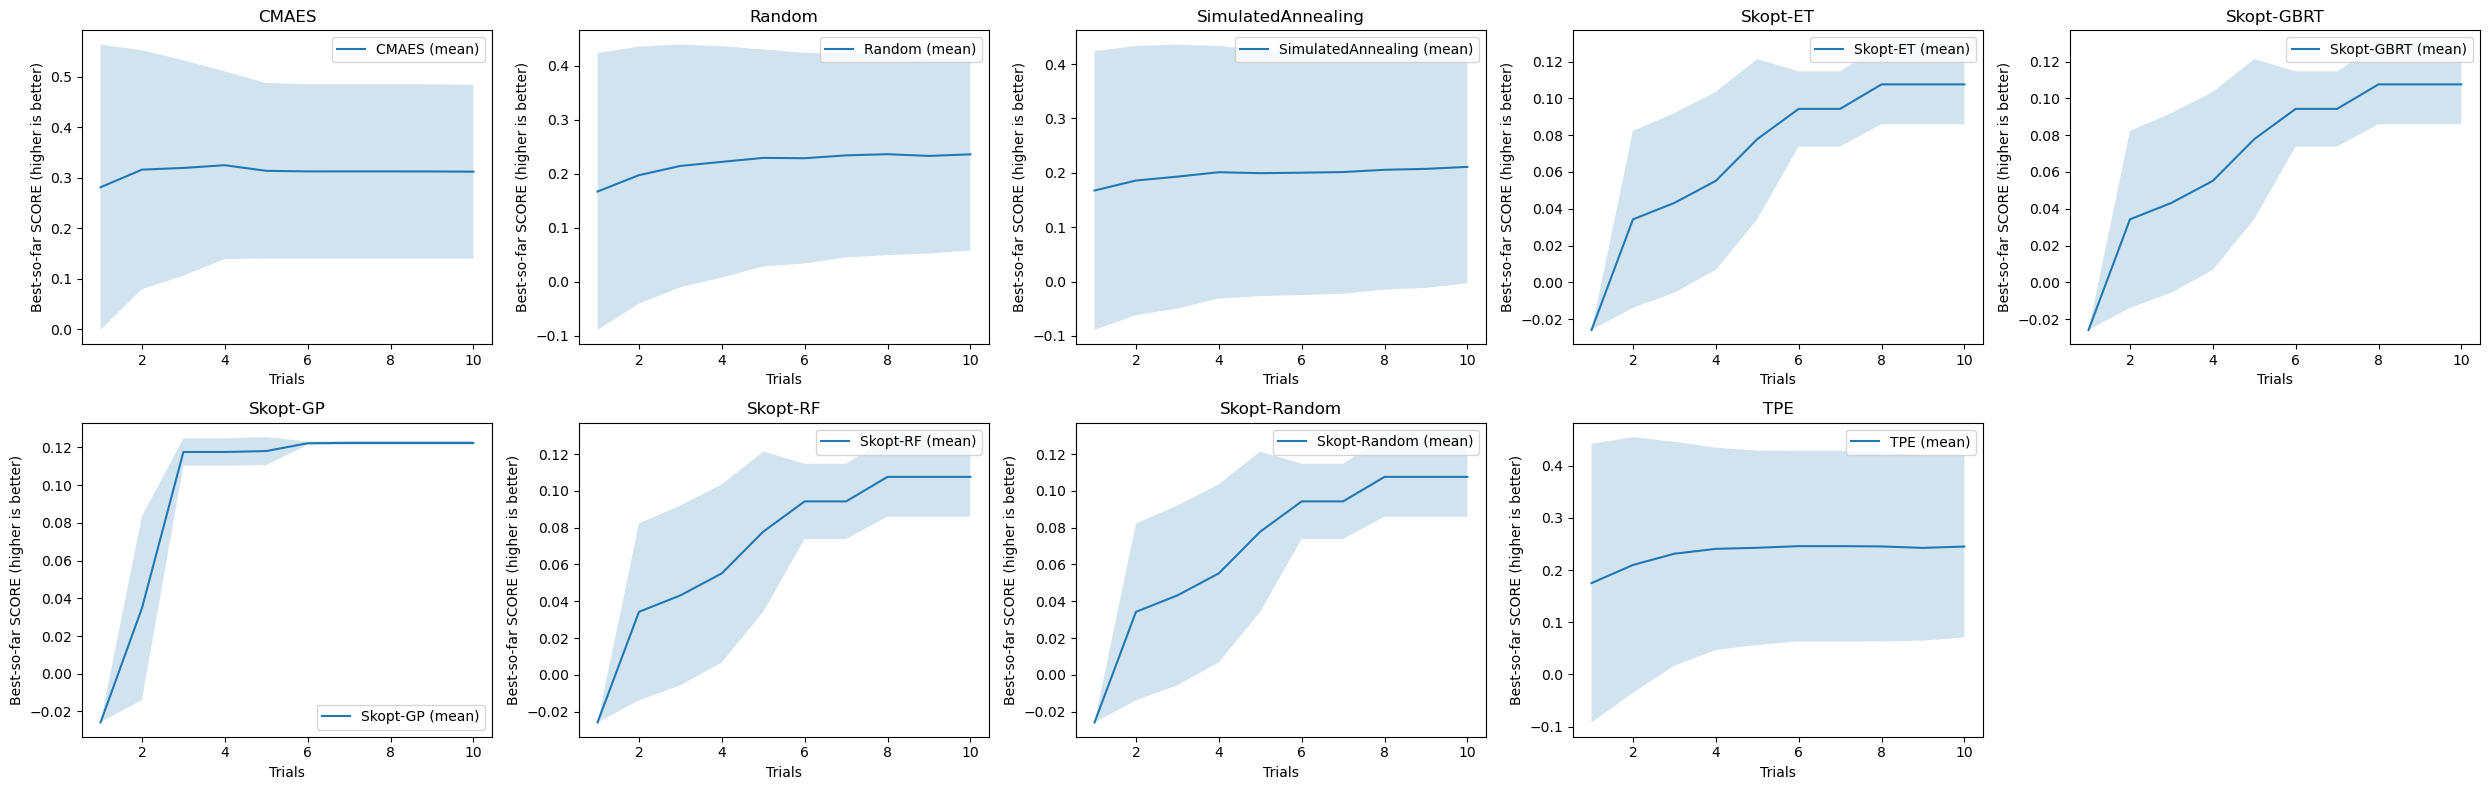

In [7]:
# === JUPYTER CELL: Plot & summarize MAXIMIZATION results (SCORE: higher is better) ===
# Assumes CSVs have columns: step,best_so_far,value,elapsed,config_json
# and best_so_far is already a cumulative MAX (higher is better).
# Also consumes per-method "*_arches.csv" saved by the harness.

from __future__ import annotations
import csv, json, ast
from pathlib import Path
from typing import Dict, List, Tuple, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------------
RESULT_DIRS = [
    "benchmark_results_nested_arch",     # <-- NEW: nested-arch harness default
    "benchmark_results_arch_var_depth",  # older harness
    "benchmark_results_class_api",       # older runs (if any)
    "benchmark_results",                 # older runs (if any)
]
OUTPUT_DIR = Path("benchmark_analytics_max")
WRITE_SUMMARY_CSV   = True
WRITE_SUMMARY_LATEX = False  # set True if you want LaTeX

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------------------------
# LOADING (curves)
# ---------------------------------------------------------------------
def load_all_curves(dirs: List[str]) -> Dict[str, List[np.ndarray]]:
    """
    Loads all result CSVs and groups them by method.
    Returns {method: [best_so_far_curve_seed0, best_so_far_curve_seed1, ...]}.
    Ignores '*_arches.csv'.
    """
    method_to_curves: Dict[str, List[np.ndarray]] = {}
    for root in dirs:
        p = Path(root)
        if not p.exists():
            continue
        for fp in p.glob("*.csv"):
            if fp.name.endswith("_arches.csv"):
                continue  # handled in a separate loader
            name = fp.stem  # e.g., "SimulatedAnnealing_seed3"
            method = name.split("_seed")[0] if "_seed" in name else name
            bests = []
            with fp.open("r", newline="") as f:
                r = csv.DictReader(f)
                for row in r:
                    v = row.get("best_so_far")
                    if v is not None and v != "":
                        try:
                            bests.append(float(v))
                        except Exception:
                            pass
            if bests:
                method_to_curves.setdefault(method, []).append(np.asarray(bests, dtype=float))
    return method_to_curves

method_to_curves = load_all_curves(RESULT_DIRS)
if not method_to_curves:
    raise FileNotFoundError(f"No result CSVs found under {RESULT_DIRS}. Did you run the benchmark?")

methods = sorted(method_to_curves.keys())

# ---------------------------------------------------------------------
# METRICS & STATS (MAXIMIZATION)
# ---------------------------------------------------------------------
def align_to_min_length(curves: List[np.ndarray]) -> Tuple[np.ndarray, int]:
    """Stack seed curves to minimal common length L → returns (A, L) where A is [n_seeds, L]."""
    L = min(len(c) for c in curves)
    A = np.vstack([c[:L] for c in curves])
    return A, L

def auc_trapz(y: np.ndarray) -> float:
    """
    Trapezoidal area under the (best-so-far) curve.
    For MAXIMIZATION with best-so-far **scores**, LARGER AUC is better.
    """
    x = np.arange(len(y), dtype=float)
    return float(np.trapz(y, x))

def compute_summary_max(method_to_curves: Dict[str, List[np.ndarray]]) -> pd.DataFrame:
    rows = []
    for m, curves in method_to_curves.items():
        A, L = align_to_min_length(curves)
        mean_curve = A.mean(axis=0)
        final_per_seed = A[:, -1]  # final best-so-far score for each seed
        rows.append({
            "method": m,
            "aligned_trials": L,
            "seeds": A.shape[0],
            "final_mean": float(final_per_seed.mean()),   # HIGHER is better
            "final_std": float(final_per_seed.std()),
            "auc_mean_curve": auc_trapz(mean_curve),      # HIGHER is better
        })
    # For MAXIMIZATION: sort DESC (higher is better)
    df = pd.DataFrame(rows).sort_values(
        ["final_mean", "auc_mean_curve"], ascending=[False, False], ignore_index=True
    )
    return df

summary_df = compute_summary_max(method_to_curves)

print("=== SUMMARY (higher is better) ===")
display(summary_df)

if WRITE_SUMMARY_CSV:
    out_csv = OUTPUT_DIR / "summary_max.csv"
    summary_df.to_csv(out_csv, index=False)
    print("Saved:", out_csv.resolve())

if WRITE_SUMMARY_LATEX:
    out_tex = OUTPUT_DIR / "summary_max.tex"
    with out_tex.open("w") as f:
        f.write(summary_df.to_latex(index=False, float_format="%.4f"))
    print("Saved:", out_tex.resolve())

# Rank table by final mean (descending)
rank_df = summary_df[["method","final_mean"]].copy()
rank_df["rank_by_final"] = rank_df["final_mean"].rank(ascending=False, method="min").astype(int)
rank_df = rank_df.sort_values(["rank_by_final","final_mean"], ascending=[True, False])
print("\n=== RANKS (by final best-so-far SCORE; higher is better) ===")
display(rank_df)

# ---------------------------------------------------------------------
# LOADING (arches tried) + nested summaries
# ---------------------------------------------------------------------
def load_arch_logs(dirs: List[str]) -> Dict[str, pd.DataFrame]:
    """
    Load '*_arches.csv' per method and concatenate across dirs.
    Returns {method: df} where df has columns [seed, step, arch_json, score].
    """
    out: Dict[str, List[pd.DataFrame]] = {}
    for root in dirs:
        p = Path(root)
        if not p.exists():
            continue
        for fp in p.glob("*_arches.csv"):
            method = fp.stem.replace("_arches", "")
            df = pd.read_csv(fp)
            # normalize column names just in case
            df = df.rename(columns={col: col.strip().lower() for col in df.columns})
            # expected: seed, step, arch_json, score
            if not {"seed","step","arch_json","score"}.issubset(df.columns):
                continue
            out.setdefault(method, []).append(df[["seed","step","arch_json","score"]].copy())
    # concat per method
    method_to_df: Dict[str, pd.DataFrame] = {}
    for m, parts in out.items():
        method_to_df[m] = pd.concat(parts, ignore_index=True)
    return method_to_df

def parse_arch_nested(s: str) -> List[List[int]]:
    """
    Accepts either:
      - flat:  [w,w,...]                   -> [[w,w,...]]
      - nested:[[w,w,...],[w,w], ...]      -> as-is
    Returns [] on failure.
    """
    try:
        obj = json.loads(s)
    except Exception:
        try:
            obj = ast.literal_eval(s)
        except Exception:
            return []

    if not isinstance(obj, list):
        return []

    # Flat list of numbers -> wrap as one sub-arch
    if all(isinstance(x, (int, float)) for x in obj):
        return [[int(x) for x in obj]]

    # Nested list: keep only sublists of numbers
    out: List[List[int]] = []
    for sub in obj:
        if isinstance(sub, list) and all(isinstance(x, (int, float)) for x in sub):
            out.append([int(x) for x in sub])
    return out


def arch_stats(arch: List[List[int]]) -> Dict[str, Any]:
    """
    Compute useful stats for nested arches:
    - n_sub: number of sub-arches
    - total_layers: sum of depths
    - sub_depth_min/mean/max
    - widths_flat: flattened width list (for histograms)
    """
    if not arch:
        return {"n_sub": 0, "total_layers": 0, "sub_depth_min": 0, "sub_depth_mean": 0.0, "sub_depth_max": 0, "widths_flat": []}
    sub_depths = [len(sub) for sub in arch]
    widths_flat = [w for sub in arch for w in sub]
    return {
        "n_sub": len(arch),
        "total_layers": int(sum(sub_depths)),
        "sub_depth_min": int(min(sub_depths)),
        "sub_depth_mean": float(np.mean(sub_depths)),
        "sub_depth_max": int(max(sub_depths)),
        "widths_flat": widths_flat,
    }

method_to_archlogs = load_arch_logs(RESULT_DIRS)

if not method_to_archlogs:
    print("\n[warn] No '*_arches.csv' files found; did you call save_arches_per_method(...) in the harness?")
else:
    # ---- Final best arch per seed (per method) ----
    rows_best = []
    for m, df in method_to_archlogs.items():
        # best per seed = row with max score per seed
        idx = df.groupby("seed")["score"].idxmax()
        best_df = df.loc[idx, ["seed", "arch_json", "score"]].copy()
        best_df.insert(0, "method", m)
        rows_best.append(best_df)
    best_arch_per_seed = pd.concat(rows_best, ignore_index=True) if rows_best else pd.DataFrame()
    print("\n=== Best arch per seed (per method) ===")
    if not best_arch_per_seed.empty:
        display(best_arch_per_seed.sort_values(["method","seed"]).reset_index(drop=True))
        best_arch_per_seed.to_csv(OUTPUT_DIR / "best_arch_per_seed.csv", index=False)
        print("Saved:", (OUTPUT_DIR / "best_arch_per_seed.csv").resolve())

    # ---- Nested-arch statistics per TRIAL ROW ----
    # Expand each row with stats so we can aggregate by method
    expanded: List[pd.DataFrame] = []
    for m, df in method_to_archlogs.items():
        tmp = df.copy()
        tmp.insert(0, "method", m)  # <-- add method column here

        parsed = tmp["arch_json"].map(parse_arch_nested)
        stats = parsed.map(arch_stats)

        tmp["n_sub"]         = stats.map(lambda d: d["n_sub"])
        tmp["total_layers"]  = stats.map(lambda d: d["total_layers"])
        tmp["sub_d_min"]     = stats.map(lambda d: d["sub_depth_min"])
        tmp["sub_d_mean"]    = stats.map(lambda d: d["sub_depth_mean"])
        tmp["sub_d_max"]     = stats.map(lambda d: d["sub_depth_max"])
        tmp["widths_flat"]   = stats.map(lambda d: d["widths_flat"])

        expanded.append(tmp)

    big = pd.concat(expanded, ignore_index=True)

    # ---- Distributions: n_sub, total_layers ----
    dist_cols = ["n_sub", "total_layers"]
    dist_frames = []
    for col in dist_cols:
        hist = big.groupby("method")[col].value_counts().rename("count").reset_index()
        hist = hist.rename(columns={col: "value"})
        hist["metric"] = col
        dist_frames.append(hist)
    dist = pd.concat(dist_frames, ignore_index=True)
    print("\n=== Distributions of n_sub and total_layers (counts of tried configs) ===")
    if not dist.empty:
        display(dist.sort_values(["metric","method","value"]).reset_index(drop=True))
        dist.to_csv(OUTPUT_DIR / "nested_dists.csv", index=False)
        print("Saved:", (OUTPUT_DIR / "nested_dists.csv").resolve())

    # ---- Per-method summary (means over tried configs) ----
    per_method = big.groupby("method").agg(
        n_trials=("score","count"),
        mean_score=("score","mean"),
        max_score=("score","max"),
        mean_n_sub=("n_sub","mean"),
        mean_total_layers=("total_layers","mean"),
        mean_sub_d_min=("sub_d_min","mean"),
        mean_sub_d_mean=("sub_d_mean","mean"),
        mean_sub_d_max=("sub_d_max","mean"),
    ).reset_index()
    print("\n=== Per-method config/score summary (over tried configs) ===")
    display(per_method.sort_values("max_score", ascending=False).reset_index(drop=True))
    per_method.to_csv(OUTPUT_DIR / "per_method_config_summary.csv", index=False)
    print("Saved:", (OUTPUT_DIR / "per_method_config_summary.csv").resolve())

    # ---- Width histogram (flattened across all layers) ----
    widths_rows = []
    for m, df in method_to_archlogs.items():
        w_all: List[int] = []
        for s in df["arch_json"]:
            w_all.extend(arch_stats(parse_arch_nested(s))["widths_flat"])
        if w_all:
            w_counts = pd.Series(w_all).value_counts().sort_index()
            widths_rows.append(pd.DataFrame({
                "method": m,
                "width": w_counts.index.astype(int),
                "count": w_counts.values.astype(int),
            }))
    width_hist = pd.concat(widths_rows, ignore_index=True) if widths_rows else pd.DataFrame()
    print("\n=== Width histogram (counts across all layers tried) ===")
    if not width_hist.empty:
        display(width_hist.sort_values(["method","width"]).reset_index(drop=True))
        width_hist.to_csv(OUTPUT_DIR / "width_histogram.csv", index=False)
        print("Saved:", (OUTPUT_DIR / "width_histogram.csv").resolve())

print("\nDone. Outputs in:", OUTPUT_DIR.resolve())

# ---------------------------------------------------------------------
# PLOTTING: small multiples (5 per row), higher is better
# ---------------------------------------------------------------------
def plot_row_of_five(methods: List[str], method_to_curves: Dict[str, List[np.ndarray]]):
    """Small multiples: up to 5 methods per row (higher is better)."""
    cols = 5
    n = len(methods)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), squeeze=False)
    for idx, m in enumerate(methods):
        r, c = divmod(idx, cols)
        ax = axes[r][c]
        A, L = align_to_min_length(method_to_curves[m])
        mean, std = A.mean(0), A.std(0)
        x = np.arange(1, L+1)
        ax.plot(x, mean, label=f"{m} (mean)")
        ax.fill_between(x, mean-std, mean+std, alpha=0.2)
        ax.set_title(m)
        ax.set_xlabel("Trials")
        ax.set_ylabel("Best-so-far SCORE (higher is better)")
        ax.legend()
    # Hide unused subplots
    for j in range(n, rows*cols):
        r, c = divmod(j, cols)
        axes[r][c].axis("off")
    plt.tight_layout()
    plt.show()

plot_row_of_five(methods, method_to_curves)
